# Text Classification 

In this assignment, you will:

1. Propose a custom text classification task and create a corpus of documents that are labeled for this task.

2. Propose discriminative features to be included in the feature vector representation for a document and evaluate their utility by training and testing Logistic Regression models.

## Write Your Name Here: Shreyas Lokesha
##### UNC-Id: 801210964
##### e-mail: slokesha@uncc.edu

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your name above.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells). 
4. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX and download a PDF version *.pdf* showing the code and the output of all cells, and save it in the same folder that contains the notebook file *.ipynb*.
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing we will see when grading!
7. Submit **both** your PDF and notebook on Canvas.

## Corpus acquisition and formatting

1. Find at least 300 documents for some topic that interests you, along with a single label for each document.

	- The more data in your collection, the better your classification models will tend to perform on it.
    

2. Partition your data into three files train.txt, dev.txt and test.txt, with training containing 80% of the documents, development 10% and test 10%.


3. All of the data must be in a common format:

    - One example per line, using the format "\<label\> \<text\>", i.e. the line starts with the label, followed by a white space, followed by the text of the document.
    - Replace all newlines in the text with \<NEWLINE\> and tab characters with \<TAB\>.
    - See corpus under *data/sentiment/* for examples.
    
    
4. Your choice of documents and labels is completely up to you. Possible sources of data:

    - **Project Gutenberg**: Metadata is available at this <a href="https://github.com/hugovk/gutenberg-metadata">Github repo</a> along with URLs for the texts. Labels here can be author, subject, genre, etc.
	- **News articles**: Crawl news articles from different domains (e.g,. CNN, FoxNews); the label for each article is the domain.
	- **Movie summaries**: Labels here can be any categorical metadata aspect (genre, release date); note real-valued metadata (like box office, runtime) can be discretized by selecting some reasonable thresholds.
	- **Tweets**: Download your own tweets. Labels here can be any categorical metadata included in the tweet, or labels you add by hand (e.g., sarcasm).
    
    
5. Additional requirements:

    - No sentiment classification.
    - **Undergraduate students**: It is acceptable to use an existing dataset, e.g. from kaggle.com or other repositories. However, it is preferable that you create your own dataset.
    - **Graduate students**: It is important that you create your own dataset. This can also serve as the basis for your project, if you choose to work on text classification for it.


### Task and Dataset description

Describe your data. What is the source of the documents, and what do the labels mean?

// YOUR CONTRIBUTION HERE <br>
The dataset compiled consists of iconic movie dialogues from Marvel and DC movies along with the labels.<br>
The labels used in the dataset are Marvel and DC and we have around 320 movie dialogues each from famous Marvel and DC movies.<br>
The name of the movie is also present as a text in the dataset marked within '\[' and '\]' symbols.<br>
Using this dataset, we perform text classification. <br>
The goal of this text classification excercise is to predict whether the movie dialogues are from Marvel or DC movies.<br>
Sources of data: rotten tomatoes website



### Dataset reading and statistics

Change the path to match the directory containing your data and execute the *read_examples()* function below.

In [104]:
import os

def read_examples(filename):
    X = []
    Y = []
    with open(filename, mode = 'r',encoding = 'utf-8') as file:
        for line in file:
            [label, text] = line.rstrip().split(' ', maxsplit = 1)
            X.append(text)
            Y.append(label)
            
    return X, Y

def label_counts(Y):
    labels = {}
    for l in Y:
        if l in labels:
            labels[l] += 1
        else:
            labels[l] = 1

    return labels


datapath = "../data/MarvelDCClassifier/"

train_file = os.path.join(datapath, 'train.txt')
trainX, trainY = read_examples(train_file)
print("Training examples:", label_counts(trainY))

dev_file = os.path.join(datapath, 'dev.txt')
devX, devY = read_examples(dev_file)
print("Development examples:", label_counts(devY))


test_file = os.path.join(datapath, 'test.txt')
testX, testY = read_examples(test_file)
print("Test examples:", label_counts(testY))

Training examples: {'Marvel': 128, 'DC': 128}
Development examples: {'Marvel': 16, 'DC': 16}
Test examples: {'Marvel': 16, 'DC': 16}


### From documents to feature vectors
This section illustratess the prototypical components of machine learning pipeline for an NLP task, in this case document classification:

1. Read document examples (train, devel, test) from files with a predefined format:
    - assume one document per line, using the format "\<label\> \<text\>".

2. Tokenize each document:
    - using a spaCy tokenizer.

3. Feature extractors:
    - so far, just words.

4. Process each document into a feature vector:
    - map document to a dictionary of feature names.
    - map feature names to unique feature IDs.
    - each document is a feature vector, where each feature ID is mapped to a feature value (e.g. word occurences).

In [53]:
import spacy
from spacy.lang.en import English
from scipy import sparse
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [54]:
# Create spaCy tokenizer.
spacy_nlp = English()

def spacy_tokenizer(text):
    tokens = spacy_nlp.tokenizer(text)
    
    return [token.text for token in tokens]

In [55]:
def read_examples(filename):
    X = []
    Y = []
    with open(filename, mode = 'r') as file:
        for line in file:
            [label, text] = line.rstrip().split(' ', maxsplit = 1)
            X.append(text)
            Y.append(label)
    return X, Y

In [56]:
def word_features(tokens):
    feats = {}
    for word in tokens:
        feat = 'WORD_%s' % word
        if feat in feats:
            feats[feat] +=1
        else:
            feats[feat] = 1
    return feats

In [57]:
def add_features(feats, new_feats):
    for feat in new_feats:
        if feat in feats:
            feats[feat] += new_feats[feat]
        else:
            feats[feat] = new_feats[feat]
    return feats

This function tokenizes the document, runs all the feature extractors on it and assembles the extracted features into a dictionary mapping feature names to feature values. It is important that feature names do not conflict with each other, i.e. different features should have different names. Each document will have its own dictionary of features and their values.

In [58]:
def docs2features(trainX, feature_functions, tokenizer):
    examples = []
    count = 0
    for doc in trainX:
        feats = {}

        tokens = tokenizer(doc)
        
        for func in feature_functions:
            add_features(feats, func(tokens))

        examples.append(feats)
        count +=1
        
        if count % 100 == 0:
            print('Processed %d examples into features' % len(examples))
    
    return examples

In [8]:
# This helper function converts feature names to unique numerical IDs.

def create_vocab(examples):
    feature_vocab = {}
    idx = 0
    for example in examples:
        for feat in example:
            if feat not in feature_vocab:
                feature_vocab[feat] = idx
                idx += 1
                
    return feature_vocab

In [59]:
# This helper function converts a set of examples from a dictionary of feature names to values representation
# to a sparse representation of feature ids to values. This is important because almost all feature values will
# be 0 for most documents and it would be wasteful to save all in memory.

def features_to_ids(examples, feature_vocab):
    new_examples = sparse.lil_matrix((len(examples), len(feature_vocab)))
    for idx, example in enumerate(examples):
        for feat in example:
            if feat in feature_vocab:
                new_examples[idx, feature_vocab[feat]] = example[feat]
                
    return new_examples

In [60]:
# Evaluation pipeline for the Logistic Regression classifier.

def train_and_test(trainX, trainY, devX, devY, feature_functions, tokenizer):
    # Pre-process training documents. 
    trainX_feat = docs2features(trainX, feature_functions, tokenizer)

    # Create vocabulary from features in training examples.
    feature_vocab = create_vocab(trainX_feat)
    print('Vocabulary size: %d' % len(feature_vocab))

    trainX_ids = features_to_ids(trainX_feat, feature_vocab)
    
    # Train LR model.
    lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000)
    lr_model.fit(trainX_ids, trainY)
    
    # Pre-process test documents. 
    devX_feat = docs2features(devX, feature_functions, tokenizer)
    devX_ids = features_to_ids(devX_feat, feature_vocab)
    
    # Test LR model.
    print('Accuracy: %.3f' % lr_model.score(devX_ids, devY))

### Feature engineering

Create two new feature functions, and include them in the *features* list.

- A passing grade will be given to generic features that apply across arbitrary text classification problems (e.g., a feature for bigrams);

- A better grade will be given for features that reveal your own understanding of your data. What features do you think will help for your particular problem? Would features based on higher level NLP processing tasks (anmed entity recognition, syntactic parsing, coreference resolution) be useful? Your grade is not tied to whether accuracy goes up or down, so be creative!

- You are free to read in any other external resources you like (dictionaries, document metadata, etc.)

In [100]:
def DCMarvel_Lexicon_extract(tokens):
    DC_Lexicon_set = set(('alfred','amazons','aquaman','arthur','arthur aurry','atlan','atlanna','atlantis','atlanteans','bat','batman','barry','barry allen','bruce wayne','clark','clark kent','codex','diana','deadshot','floyd lawton',
                         'darksiede','doomsday','dent','enigma','enchantress','faora','gotham','harley quinn','harvey','harvey dent','joker','jor-el','kal','kal-el','krypton','kryptonite','kryptonian','lex','luthor','lois','lois lane','martha','ocean master','orm','parademons','steppenwolf','superman',
                         'trevor','two-face','wayne','zod'))
    Marvel_Lexicon_set = set(('agent','asgard','asgardian','askervarian','avenger','avengers','bifrost','bucky','cap','captain','chitauri','coulson','dormammu','eytri','fandral','frigga','gamora','groot','hank','hulk','hydra','jarvis','jane','jotunheim','knowhere','loki',
                             'odin','panther','parker','pepper','peter','phil','pym','quill','rocket','shield','sif','steve','stark','strange','spider','tesseract','thanos','thor'))
    lex_feat = {}
    for item in tokens:
        tempStore = item.lower()
        if(tempStore in DC_Lexicon_set):
            entry = "DCLex_"+str(item)
            if(entry not in lex_feat):
                lex_feat[entry] = 1
            else:
                lex_feat[entry] += 1
        if(tempStore in Marvel_Lexicon_set):
            entry = "MarvelLex_"+str(item)
            if(entry not in lex_feat):
                lex_feat[entry] = 1
            else:
                lex_feat[entry] += 1
                
    return lex_feat
            

In [101]:
def DCMarvel_MovieName_Lex(tokens):
    DC_Movies = set(('aquaman','batman begins','batman v superman: dawn of justice','justice league','man of steel','suicide squad','the dark knight','the dark knight rises','wonder woman'))
    Marvel_Movies = set(('ant-man','ant-man and the wasp','avengers: age of ultron','avengers:infinity war','avengers:endgame','captain america:the first avenger',
                         'captain america:the winter soldier','captain america: civil war','doctor strange','guardians of the galaxy','iron man','iron man 2','the avengers','the incredible hulk','thor','thor:the dark world'
                         ,'thor:ragnarok'))
    
    feat_movies = {'DC_Mov':0,'Marvel_Mov':0}
    movie_name = ''
    index = 0
    dc_mov_count = 0
    marvel_mov_count = 0
    stg = ''
    for item in tokens:
        if('[' in item):
            index = tokens.index(item)
            subIndex = item.index('[')
            stg = stg + item[subIndex+1:]
            if(tokens[index] != ']'):
                index = index + 1
                movie_name = movie_name + stg + " " + tokens[index]+" "
                
    dc_match = False
    marvel_match = False
    preprocessStg = movie_name.lower().rstrip()
    for movie in DC_Movies:
        if(movie == preprocessStg):
            dc_match = True
            feat_movies['DC_Mov'] += 1
    
    for movie in Marvel_Movies:
        if(movie == preprocessStg):
            marvel_match = True
            feat_movies['Marvel_Mov'] += 1
    
    
               
    return feat_movies
    


Evaluate the impact of your features by training and testing with and without each feature.

In [126]:
import os

datapath = '../data/MarvelDCClassifier'

train_file = os.path.join(datapath, 'Train.txt')
trainX, trainY = read_examples(train_file)

dev_file = os.path.join(datapath, 'Dev.txt')
devX, devY = read_examples(dev_file)

# Specify features to use. Do this multiple times, with and without the new features
features = [word_features,DCMarvel_MovieName_Lex]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Vocabulary size: 1500
Accuracy: 0.875


## Plot ROC Curve

*Mandatory for graduate students, optional for undergraduate students.*

Take your best classifier and plot a <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">Receiver Operating Characteristic (ROC)</a> curve by varying a threshold on the probabilistic output. You can use the <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html">sklearn implementation</a>, or implement your own.

Processed 100 examples into features
Processed 200 examples into features
Accuracy: 0.875


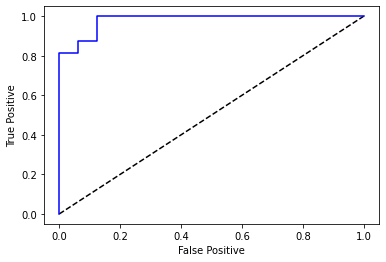

In [127]:
# YOUR CODE HERE
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

train_file = os.path.join(datapath, 'Train.txt')
trainX, trainY = read_examples(train_file)
dev_file = os.path.join(datapath, 'Dev.txt')
devX, devY = read_examples(dev_file)
feature_functions = [word_features,DCMarvel_Lexicon_extract]
trainX_feat = docs2features(trainX, feature_functions, spacy_tokenizer)
feature_vocab = create_vocab(trainX_feat)
trainX_ids = features_to_ids(trainX_feat, feature_vocab)
lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000)
lr_model.fit(trainX_ids, trainY)
devX_feat = docs2features(devX, feature_functions, spacy_tokenizer)
devX_ids = features_to_ids(devX_feat, feature_vocab)
print('Accuracy: %.3f' % lr_model.score(devX_ids, devY))
lr_probability = lr_model.predict_proba(devX_ids)[:,1]
devY_class = []
for item in devY:
    if(item == 'DC'):
        devY_class.append(0)
    else:
        devY_class.append(1)
        
fpr,tpr,threshold = roc_curve(devY_class,lr_probability)

plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr,color="blue")
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.show()

## Bonus points ##

Anything extra goes here.


In [123]:
def DCMarvel_Lex_counter(tokens):
    DC_Lexicon_set = set(('alfred','amazons','aquaman','arthur','arthur aurry','atlan','atlanna','atlantis','atlanteans','bat','batman','barry','barry allen','bruce wayne','clark','clark kent','codex','diana','deadshot','floyd lawton',
                         'darksiede','doomsday','dent','enigma','enchantress','faora','gotham','harley quinn','harvey','harvey dent','joker','jor-el','kal','kal-el','krypton','kryptonite','kryptonian','lex','luthor','lois','lois lane','martha','ocean master','orm','parademons','steppenwolf','superman',
                         'trevor','two-face','wayne','zod'))
    Marvel_Lexicon_set = set(('agent','asgard','asgardian','askervarian','avenger','avengers','bifrost','bucky','cap','captain','chitauri','coulson','dormammu','eytri','fandral','frigga','gamora','groot','hank','hulk','hydra','jarvis','jane','jotunheim','knowhere','loki',
                             'odin','panther','parker','pepper','peter','phil','pym','quill','rocket','shield','sif','steve','stark','strange','spider','tesseract','thanos','thor'))
    
    feat_DCMCounter = {"DC_Lex_count":0,"Marvel_Lex_count": 0}
   
    for item in tokens:
        if(item.lower() in DC_Lexicon_set):
            feat_DCMCounter["DC_Lex_count"] += 1
        elif(item.lower() in Marvel_Lexicon_set):
            feat_DCMCounter["Marvel_Lex_count"] += 1
    
    return feat_DCMCounter


import os

datapath = '../data/MarvelDCClassifier'
train_file = os.path.join(datapath, 'Train.txt')
trainX, trainY = read_examples(train_file)

dev_file = os.path.join(datapath, 'Dev.txt')
devX, devY = read_examples(dev_file)

# Specify features to use. Do this multiple times, with and without the new features
features = [word_features,DCMarvel_Lex_counter]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)     
    

Processed 100 examples into features
Processed 200 examples into features
Vocabulary size: 1500
Accuracy: 0.938


## Analysis ##
Include an analysis of the results that you obtained in the experiments above.